# Persistent single-linkage (HDBSCAN) clustering on sparse matrices

This is our attempt at running an HDBSCAN approach (persistent single linkage) on a sparse distance matrix. We need to figure out how to include densities (and what densities to use), and how to feed it to HDBSCAN directly.

The sparse distance matrices are obtained via transformation of the original UMAP weights OR original KNN-weights OR from some edge pruning strategies.

In [1]:
!git branch

  concensus
* master


In [2]:
execfile('functions/data_specifics.py')
execfile('functions/graph_functions.py')
print(data_set_list)

['pendigits', 'coil', 'mnist', 'usps', 'buildings', 'clusterable']


In [3]:
from IPython.display import display, Markdown, Latex
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn import cluster

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import umap
from collections import Counter
from scipy.stats import mode

sns.set()

In [4]:
import hdbscan
import scipy.sparse
import sklearn.cluster
from hdbscan._hdbscan_tree import (
    condense_tree,
    compute_stability,
    get_clusters,
    outlier_scores,
)
from hdbscan.plots import CondensedTree, SingleLinkageTree, MinimumSpanningTree

## Get clusters from a (disconnected) sparse distance matrix

* The 0-values indicate "far away" points

If the matrix has disconnected components (when viewed as a graph), HDBSCAN does not work. To get around this, we have tried clustering each component separately or just adding edges to glue the different parts together.

In [5]:
def hdbscan_on_graph(distance_graph):
    if scipy.sparse.csgraph.connected_components(distance_graph)[0] > 1:
        n_components, components = scipy.sparse.csgraph.connected_components(distance_graph)
        rj_labels = np.full(distance_graph.shape[0], -1, dtype=np.int64)
        for i in range(n_components):
            if np.sum(components == i) <= 90:
                subgraph_labels = np.zeros(np.sum(components == i), dtype=np.int64)
            else:
                subgraph = distance_graph[components == i, :][:, components == i]
                subgraph_labels = hdbscan.HDBSCAN(metric="precomputed", min_samples=2, min_cluster_size=30, allow_single_cluster=subgraph.shape[0] < 300).fit_predict(subgraph)
            subgraph_labels[subgraph_labels >= 0] += (rj_labels.max() + 1)
            rj_labels[components == i] = subgraph_labels
            # print(i, np.sum(components == i), Counter(subgraph_labels))
    else:
        rj_labels = hdbscan.HDBSCAN(metric="precomputed", min_samples=2, min_cluster_size=30).fit_predict(distance_graph)
    return(rj_labels)

# Matrix transformations

We are trying different edge weights before applying clustering the graph.

The 4 matrices we get from UMAP are:
* A_w is a sparse, non-symmetric matrix containing the umap weights (csr)
* A_umap is the symmetrized version of A_w (csr)
* dists is a sparse matrix containing the high dimensional distances (csr)
* knn_dists is a dense matrix of size (number of points)x(k) containing the distance to the kNN in ascending order


In [30]:
# Inverse values (this is an attempt for going from similarities to dissimilarities)
def get_inverse_sim(A):

    D = A.copy()
    m = min(A.data)
    if(m<0.001):
        m = 0.001
    else:
        m = 0
    v = np.array([1/(x+m) for x in A.data])
    D.data = v
        
    return(D)

def get_invlog_sim(A):

    D = A.copy()
    data = D.data/max(D.data)
    v = -1*np.log(data)
    D.data = v
        
    return(D)

# This is another attempt for going from similarities to dissimilarities
def get_negative_sim(A):

    D = A.copy()
    m = 1
    if(max(A.data)>1):
        m = max(A.data)
    v = np.array([1-(x/m) for x in A.data])
    D.data = v
        
    return(D)

# Romeo and Juliet: each edge weights is replaced by the average of weights (including 0-weight)
# between the two endpoints' neighborhoods. If a node appears in both neiborhoods, we "clone"
# it and add an edge of weight 1 between the node and itself.
def neighborhood_amplification(W, alpha = 0.5):
    A = 1*(W!=0)
    I = scipy.sparse.identity(A.shape[0])
    
    d = A.sum(axis=0).tolist()[0]
    D_inv = scipy.sparse.diags([1/x for x in d])
    
    # + I is to include self-loops with edge weights of 1.
    
    # A : unweighted adjacency
    # W : weighted adjacency
    # D_inv : diagonal matrix of 1/d_i
    M = D_inv*((A.T*(W+I)*A).multiply(A))*D_inv
    P = (W+M) - W.multiply(M)
    
    #  mix_ratio(x+y-x*y) + (1-mix_ratio)(x*y)
    R = ((1-alpha)*W+alpha*M)
    
    # R = alpha*(M+W-P) + (1-alpha)*(P)
    return(R)

# Count number of 1, 3 and 4 cycles and edge is involved in
def get_egonet_distance(A_umap, plot_distribution=False):
    # Make the matrix binary
    A = 0.5*(A_umap!=0)
    
    counts = A.multiply(A + A*A + A*A*A)
    
    D = counts.copy()
    D.data = np.array([1/x for x in D.data])
        
    return(D)

def get_triangle_distance(A_w):
    # Make the matrix binary
    A = 1*(A_w!=0)
    # Count number of triangles in which each pair of node is involved
    counts = A.multiply(A*A)
    
    C = dict()
    N = max(counts.data)
    for n in range(1,N+1):
        C[n] = (counts==n)*1/n
    D_count = C[2]
    for n in range(3,N+1):
        D_count += C[n]
    B = (A.copy())*0.001
    BisBigger = B>D_count
    D = D_count - D_count.multiply(BisBigger) + B.multiply(BisBigger)
    return(D)

# Replace high dimensional points by the centroid of their neighbors
def get_avg_neighbor_distance(raw_data, k=8):
    A_w = knn_adjacency(X=raw_data, k=k)
    w_d = np.mean(A_w.sum(axis=1))
    family_data = (1/w_d)*(A_w.T)*raw_data
    
    # if(k is None):
    #     k = get_dataset_params(dataset_id)['n_neighbors']

    A_umap, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(X=family_data, 
                                                     n_neighbors=k, 
                                                     random_state=0, 
                                                     metric='euclidean', 
                                                     return_dists=True,
                                                    set_op_mix_ratio=0.5)

    # D = get_inverse_sim(A_umap)
    D = get_invlog_sim(A_umap)
    return(D)

# Clustering algorithm
These are the steps we use to feed a sparse distance matrix to the single linkage...
We are not using HDBSCAN at the moment, but this is where we would like to go.

## Run for all other data sets

In [31]:
def get_single_linkage_clustering(dataset_id, distance_function, k=None):
    raw_data, targets, dataset_name = get_dataset(dataset_id=dataset_id)
    display(Markdown(f'### {dataset_name}'))
    
    if(distance_function.__name__ == "get_avg_neighbor_distance"):
        D = distance_function(raw_data)
    else:
        if(k is None):
            k = get_dataset_params(dataset_id)['n_neighbors']

        A_umap, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(X=raw_data, 
                                                         n_neighbors=k, 
                                                         random_state=0, 
                                                         metric='euclidean', 
                                                         return_dists=True,
                                                         set_op_mix_ratio=0.5)
        D = distance_function(A_umap)

    labels = hdbscan_on_graph(D)

    ari = adjusted_rand_score(targets, labels)
    ami = adjusted_mutual_info_score(targets, labels)
    print(f'ARI = {ari} and AMI = {ami}')
    return(labels, ari, ami, targets)

In [32]:
experimentList = [
  {'description' : 'UMAP weights (inv)', 'function': get_inverse_sim},
   {'description' : 'UMAP weights (inv-log)', 'function': get_invlog_sim},
  # {'description' : 'UMAP weights (neg)', 'function': get_negative_sim},
  {'description' : 'Number of supporting triangles', 'function': get_triangle_distance},
  {'description' : "Average of UMAP weight and mean families' weights", 'function': neighborhood_amplification},
  {'description' : 'Number of 1,3,4-cycles containg the two endpoints', 'function': get_egonet_distance},
  # {'description' : "UMAP of modified data points: neighbors' average", 'function': get_avg_neighbor_distance}
]

### Refinement/coarsening measure

Here, we define a measure to measure how much a partition is the refinement of another partition. To decide if partition_1 is a refinement of partition_2, we map all parts of partition_1 to to the part of partition_2 with the largest overlap. We then add the number of elements not in the overlap. A high value means that it is not a refinement.

In [33]:
def measure_refinement(targets, labels):
    ind_max = max(labels)+1
    ind_min = min(labels)
    not_in_dominant = 0
    for grp in range(ind_min,ind_max):
        subtargets = targets[labels==grp]
        sizeLarge = mode(subtargets)[1][0]
        not_in_dominant = not_in_dominant + (len(subtargets)-sizeLarge)
    return(1 - not_in_dominant/len(targets))

In [34]:
# raw_data, targets, dataset_name = get_dataset(dataset_id=2)
# display(Markdown(f'### {dataset_name}'))

# k = get_dataset_params(dataset_id)['n_neighbors']

# A_umap, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(X=raw_data, 
#                                                  n_neighbors=k, 
#                                                  random_state=0, 
#                                                  metric='euclidean', 
#                                                  return_dists=True,
#                                                  set_op_mix_ratio=0.5)

# D = get_triangle_distance(A_umap)

# labels = hdbscan_on_graph(D)

In [35]:
results_ari_ami = []

for j, exp in enumerate(experimentList):
    
    description = exp['description']
    function = exp['function']
    display(Markdown(f'# {description}'))
    
    for i in range(5):
        labels, ari, ami, targets = get_single_linkage_clustering(dataset_id=i, 
                                      distance_function = function, k=10)
        results_ari_ami.append([f'Experiment {j}' , 
                                get_dataset_name(i), 
                                description, 
                                ari, 
                                ami, 
                                sum(labels==-1)/len(labels),
                                max(targets)+1,
                                max(labels)+1,
                                mode(targets)[1][0],
                                mode(labels)[1][0],
                                measure_refinement(targets, labels),
                                measure_refinement(labels, targets)
                                ])
        
results_df_10 = pd.DataFrame(results_ari_ami, 
                          columns=['Experiment', 'Dataset', 'Description', 'ARI', 'AMI', 'Percent noise', 
                                   'Nb clusters (true)', 'Nb clusters (predicted)', 'Largest cluster (true)', 'Largest cluster(predicted)', 
                                   'Refinement', 'Coarsening'])

# UMAP weights (inv)

### pendigits

ARI = 0.10760290789421745 and AMI = 0.4108592755650803


### coil

ARI = 0.9631727323967534 and AMI = 0.983457310797028


### mnist

ARI = 0.00015400737405604065 and AMI = 0.003181136249917091


### usps

ARI = 0.0792216268507797 and AMI = 0.3053040058148915


### buildings

ARI = 0.06161525293465001 and AMI = 0.5278478683947923


# UMAP weights (inv-log)

### pendigits

ARI = 0.1871806848107086 and AMI = 0.5366560282068829


### coil

ARI = 0.723156535377369 and AMI = 0.9336630616611129


### mnist

ARI = 0.0003158263955898019 and AMI = 0.0016665881221223642


### usps

ARI = 0.056689939148730606 and AMI = 0.407579962449701


### buildings

ARI = 0.04491206385123997 and AMI = 0.47684963129507213


# Number of supporting triangles

### pendigits

ARI = 0.01168454062223058 and AMI = 0.15549627139945613


### coil

ARI = 0.203789140935227 and AMI = 0.6904772749748082


### mnist

ARI = 0.012577133658181654 and AMI = 0.036367350431426144


### usps

ARI = 0.019431748866495596 and AMI = 0.032725764607458664


### buildings

ARI = 0.007965082173651541 and AMI = 0.10207949700523525


# Average of UMAP weight and mean families' weights

### pendigits

ARI = 0.024150736161477313 and AMI = 0.07507327263140963


### coil

ARI = 0.11968131443279263 and AMI = 0.5591225308426037


### mnist

ARI = 0.0029438562618441266 and AMI = 0.012730902742304732


### usps

ARI = 0.0038470119032238724 and AMI = 0.07874712986347464


### buildings

ARI = 0.0027140888848530167 and AMI = 0.06358220284359249


# Number of 1,3,4-cycles containg the two endpoints

### pendigits

ARI = 0.6466309876982249 and AMI = 0.7828123203861272


### coil

ARI = 0.5258133307993058 and AMI = 0.8291732327349852


### mnist

ARI = 0.04690513764060889 and AMI = 0.1563456539853301


### usps

ARI = 0.23021871062166713 and AMI = 0.45232048880356945


### buildings

ARI = 0.002763489666887864 and AMI = 0.07681202147341325


In [36]:
results_df_10.sort_values(['Experiment', 'Dataset'])

,Experiment,Dataset,Description,ARI,AMI,Percent noise,Nb clusters (true),Nb clusters (predicted),Largest cluster (true),Largest cluster(predicted),Refinement,Coarsening
4,Experiment 0,buildings,UMAP weights (inv),0.061615,0.527848,0.398037,41,50,334,1663,0.480613,0.509095
1,Experiment 0,coil,UMAP weights (inv),0.963173,0.983457,0.004861,21,20,72,99,0.979861,0.976389
2,Experiment 0,mnist,UMAP weights (inv),0.000154,0.003181,0.318543,10,3,4002,23780,0.115314,0.679429
0,Experiment 0,pendigits,UMAP weights (inv),0.107603,0.410859,0.035615,10,3,183,1383,0.312187,0.962159
3,Experiment 0,usps,UMAP weights (inv),0.079222,0.305304,0.415573,11,15,1553,3864,0.348892,0.590987
9,Experiment 1,buildings,UMAP weights (inv-log),0.044912,0.476850,0.432264,41,50,334,1806,0.438009,0.504548
6,Experiment 1,coil,UMAP weights (inv-log),0.723157,0.933663,0.005556,21,19,72,288,0.848611,0.948611
7,Experiment 1,mnist,UMAP weights (inv-log),0.000316,0.001667,0.363886,10,2,4002,22232,0.115257,0.635200
5,Experiment 1,pendigits,UMAP weights (inv-log),0.187181,0.536656,0.050083,10,4,183,1181,0.410128,0.947691
8,Experiment 1,usps,UMAP weights (inv-log),0.056690,0.407580,0.558937,11,44,1553,5197,0.490966,0.597118


In [37]:
results_df = results_df_10

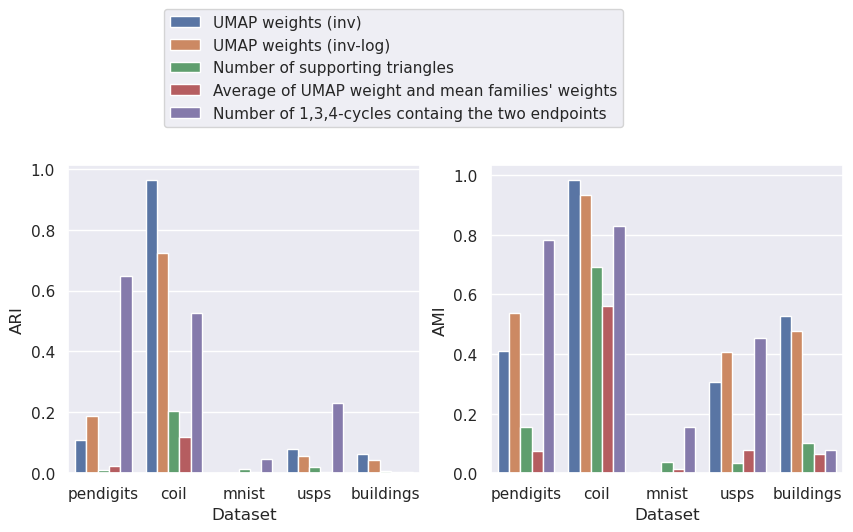

In [38]:
# fig = plt.figure(figsize=(8, 6), dpi=80)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.barplot(data=results_df, x='Dataset', y='ARI', 
            hue='Description', ax=ax1)
sns.barplot(data=results_df, x='Dataset', y='AMI', 
            hue='Description', ax=ax2)
lgd = ax1.legend(loc='lower left', bbox_to_anchor=(0.25,1.1))
ax2.legend_.remove()
# sns.barplot(data=results_df, x='Dataset', y='AMI', hue='Description', ax=ax2)
# # lgd = sns.move_legend(ax, "upper center", bbox_to_anchor=(1, 1))
# plt.savefig('ExperimentSummary_ari_ami.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

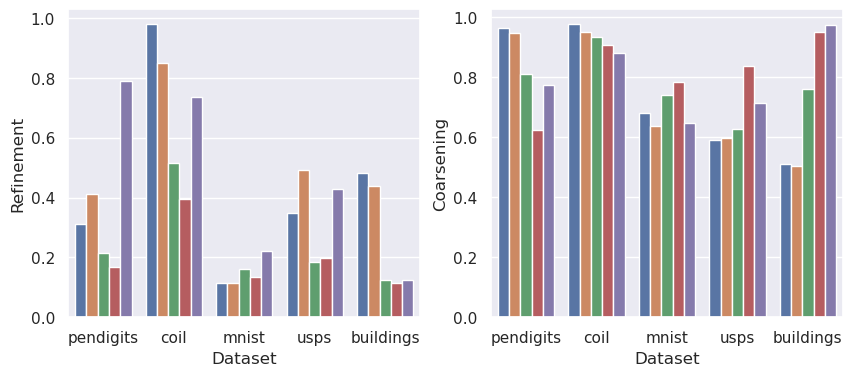

In [39]:
# fig = plt.figure(figsize=(8, 6), dpi=80)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.barplot(data=results_df, x='Dataset', y='Refinement', 
            hue='Description', ax=ax1)
sns.barplot(data=results_df, x='Dataset', y='Coarsening', 
            hue='Description', ax=ax2)
# lgd = ax1.legend(loc='lower left', bbox_to_anchor=(0.25,1.1))
ax2.legend_.remove()
ax1.legend_.remove()
# sns.barplot(data=results_df, x='Dataset', y='AMI', hue='Description', ax=ax2)
# # lgd = sns.move_legend(ax, "upper center", bbox_to_anchor=(1, 1))
# plt.savefig('ExperimentSummary_refine_coarse.png', bbox_inches='tight')

### Problem with get_negative_sim transformation

Not sure why, but the following line does not work when D is obtained from : D =  get_negative_sim(A_umap)

single_linkage_tree = sklearn.cluster._hierarchical_fast._single_linkage_label(mst_array)

In [11]:
dataset_id=0
raw_data, targets, dataset_name = get_dataset(dataset_id)
display(Markdown(f'### {dataset_name}'))

k = get_dataset_params(dataset_id)['n_neighbors']

A_umap, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(X=raw_data,  
                                                              n_neighbors=k, 
                                                                 random_state=0, 
                                                                 metric='euclidean', 
                                                                 return_dists=True,
                                                                 set_op_mix_ratio=0.5)
D =  get_invlog_sim(A_umap)

labels = hdbscan_on_graph(D)

ari = adjusted_rand_score(targets, labels)
ami = adjusted_mutual_info_score(targets, labels)
print(f'ARI = {ari} and AMI = {ami}')

### pendigits

ARI = 0.18672142560283936 and AMI = 0.5437746812445351


## Summarize what I have done

Ran persistant clustering games on different "dissimilarity matrices". The matrices I have looked at are the following (when a similarity matrix is given, for instance UMAP, we have transformed it, using its elementwise inverse).

The different weights tried for each edge are:

* UMAP weight - no neighborhood information added
* Number of supporting triangles (or size of intersection of the two neighborhoods)
* Average of edge (and non-edge) weights between the two neighborhoods added to the original UMAP weight - this is what is discussed in the original post here.
* Number of cycles of length 1, 3 and 4 (cycles of length 1 are just edges, this is to avoid disconnecting the graph)
* UMAP weight of modified high dimensional representations. Each point is represented as its neighbors' average point.

I also want to include the Weisserstein distance between the high dimensional neighborhoods, if someone can point me to code I could use that would be helpful?